In [1]:
import pandas as pd
import numpy as np

Parameters for the Analysis

In [2]:
analysis_years = np.arange(1997, 2015, 1) # 2015 data does not have International Sunspot Number, so excluding it

noaa_filenames =[]
noaa_DSD_filenames=[]
noaa_DPD_filenames=[]
noaa_ACE_SWEPAM_filenames=[]
for analysis_year in analysis_years: 
    noaa_filenames.append(str(analysis_year) + '.txt') 
    noaa_DSD_filenames.append(str(analysis_year) + '_DSD.txt')
    noaa_DPD_filenames.append(str(analysis_year) + '_DPD.txt')
    if analysis_year >= 1998 : # This dataset did not begin until 1998
        noaa_ACE_SWEPAM_filenames.append('ACE_SWEPAM_' + str(analysis_year))

Read in SOHO-LASCO CME Catalog (All Available Years)

In [3]:
# Import Catalog of Coronal Mass Ejection Data
# Data is in fixed width file format
data_file = 'SOHO-LASCO_CME_Catelog_univ_all.txt'
colspecs = [(0,10), (12,20), (24,27), (32,34), (37,41), (45,49), (52,56), (59,63), (66,72), (72,73), (76,83), (83,84), (87,94), (94,95), (98,101), (104, 147)]
names = ['Date', 'Time', 'CentralPA', 'Width', 'LinearSpeed', 'Initial', 'Final', '20R', 'Accel', 'AFlag', 'Mass', 'MFlag', 'KineticEnergy', 'KEFlag', 'MPA',
'Remarks']
cme = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs, skiprows=4)
# Create the index as a datetime
cme.index = pd.to_datetime(cme.Date)

#cme.convert_objects(convert_numeric=True).dtypes # some columns can be converted 
cols_to_convert_to_float64 = ['CentralPA', 'LinearSpeed', 'Initial', 'Final', '20R', 'Accel', 'Mass', 'KineticEnergy']
for col in cols_to_convert_to_float64:
    cme[col] = pd.to_numeric(cme[col], errors='coerce')

cme = cme[(cme.index.year >= analysis_years[0]) & (cme.index.year <= analysis_years[len(analysis_years) - 1])]
cme.shape

(24648, 16)

Create a series to analyze Linear Speed.  Create 1 entry per date with max of LinearSpeed

In [4]:
linear_max = cme.groupby([cme.index])['LinearSpeed'].max()
#linear_max = linear_max[(linear_max.index.year==analysis_year)]


Create a series to analyze 20R - the speed at 20 Solar Radii.  Create 1 entry per date using the max of 20R

In [5]:
c20R_max = cme.groupby([cme.index])['20R'].max()
#c20R_max = c20R_max[(c20R_max.index.year==analysis_year)]

Create a series that is the count of the cme's on a particular date

In [6]:
cme_count = cme.groupby([cme.index])['Date'].count()

Read in NOAA files of Geomagnetic data

In [7]:

colspecs = [(0,2), (2,4), (4,6), (6,10), (10,12), (12,14), (14,16), (16,18), (18,20), (20,22), (22,24), (24,26), (26,28), (28,30), 
            (58,60), (61, 62), (62,65)]
names = ['Year', 'Month', 'Day', 'Bartels', 'BDay', 'Kp0', 'Kp3', 'Kp6', 'Kp9', 'Kp12', 'Kp15', 'Kp18', 'Kp21', 'KpSum', 'Cp',
'C9', 'ISN']

first_file = True

for data_file in noaa_filenames:
    if first_file:
        noaa = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs)
        first_file = False
    else:
        noaa_file = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs)
        noaa = pd.concat([noaa, noaa_file])


In [8]:
noaa.loc[noaa['Year']>=95,['Year']] = 1900 + noaa.loc[noaa['Year']>=95,['Year']]
noaa.loc[noaa['Year']<=15,['Year']] = 2000 + noaa.loc[noaa['Year']<=15,['Year']]

# Create datetime index using the individual columns for Year, Month and Day
str_date =  noaa.Year.astype(str) + '/' + noaa.Month.astype(str) + '/' + noaa.Day.astype(str)
noaa['Date'] = pd.to_datetime(str_date, yearfirst=True)
noaa.index = noaa.Date
noaa['ISN'] = pd.to_numeric(noaa['ISN'], errors='coerce')

In [9]:
# Time shifting the C9 data in 1 day increments for 5 days so that we can compare solar activity to future space weather on Earth
C9 = noaa.C9
for n in range(5,-6,-1):
        shifted_forward =  C9.shift(n)  
        if n > 0:
                rsuffix =  str(-n)
        elif n < 0:
                rsuffix = '+' + str(-n)
        else:
                rsuffix = '_0'
                
        noaa = noaa.join(shifted_forward, rsuffix=rsuffix)
 
noaa.tail()

Year  Month  Day  Bartels  BDay  Kp0  Kp3  Kp6  Kp9  Kp12  ...   \
Date                                                                   ...    
2014-12-27  2014     12   27     2474    27   33   20   13   17    17  ...    
2014-12-28  2014     12   28     2475     1   23   20   13   13    13  ...    
2014-12-29  2014     12   29     2475     2   20   30   23   33    37  ...    
2014-12-30  2014     12   30     2475     3   30   40   37   20    30  ...    
2014-12-31  2014     12   31     2475     4   13   23   13   17    20  ...    

            C9-4  C9-3  C9-2  C9-1  C9_0  C9+1  C9+2 C9+3  C9+4  C9+5  
Date                                                                   
2014-12-27   3.0   4.0   3.0   4.0     1   2.0   5.0  4.0   2.0   NaN  
2014-12-28   4.0   3.0   4.0   1.0     2   5.0   4.0  2.0   NaN   NaN  
2014-12-29   3.0   4.0   1.0   2.0     5   4.0   2.0  NaN   NaN   NaN  
2014-12-30   4.0   1.0   2.0   5.0     4   2.0   NaN  NaN   NaN   NaN  
2014-12-31   1.0   2.0   5.0   4.0     2   NaN   NaN  NaN   NaN   NaN  

[5 rows x 29 columns]

Read in the Daily Solar Data

In [10]:

colspecs = [(0,4), (5,7), (8,10), (12,16), (19,23), (27,32), (36,39), (49,54), (55,57), (58,60), (61,63), (64,66), (68,70), (71,73), 
            (74,76)]
names = ['Year', 'Month', 'Day', 'RadioFlux', 'SESC_SSN', 'SS_AREA', 'NEW_REGIONS', 'XrayBgndFlux', 'C', 'M', 'X', 'S', 'Opt1', 'Opt2', 'Opt3']

first_file = True

for data_file in noaa_DSD_filenames:
    if first_file:
        noaa_DSD = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs, skiprows=12)
        first_file = False
    else:
        noaa_DSD_file = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs, skiprows=12)
        noaa_DSD = pd.concat([noaa_DSD, noaa_DSD_file])

# Create datetime index using the individual columns for Year, Month and Day
str_date = noaa_DSD.Year.astype(str) + '/' + noaa_DSD.Month.astype(str) + '/' + noaa_DSD.Day.astype(str)
noaa_DSD.to_csv('../data/noaa_DSD.csv')
str_date
noaa_DSD['Date'] = pd.to_datetime(str_date, yearfirst=True)
noaa_DSD.index = noaa_DSD.Date
noaa_DSD.drop(['Year', 'Month', 'Day', 'Date'], axis=1, inplace=True)



Read in the Daily Particle Data

In [11]:
colspecs = [(0,4), (5,7), (8,10), (14,21), (23,30), (32,39), (42,49), (53,60)]
names = ['Year', 'Month', 'Day', 'P1MeV', 'P10MeV', 'P100MeV', 'E08MeV', 'E2MeV']

first_file = True

for data_file in noaa_DPD_filenames:
    if first_file:
        noaa_DPD = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs, skiprows=12)
        first_file = False
    else:
        noaa_DPD_file = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs, skiprows=12)
        noaa_DPD = pd.concat([noaa_DPD, noaa_DPD_file])

# Create datetime index using the individual columns for Year, Month and Day
str_date = noaa_DPD.Year.astype(str) + '/' + noaa_DPD.Month.astype(str) + '/' + noaa_DPD.Day.astype(str)
noaa_DPD.to_csv('../data/noaa_DPD.csv')

noaa_DPD['Date'] = pd.to_datetime(str_date, yearfirst=True)
noaa_DPD.index = noaa_DPD.Date
noaa_DPD.drop(['Year', 'Month', 'Day', 'Date'], axis=1, inplace=True)




Read in Solar Wind Data

In [12]:
def convertDOY(doy, year):
    str_date = year + '/1/1' 
    int_doy = doy.astype(int)
    return pd.to_datetime(str_date, yearfirst=True) + pd.DateOffset(days=int_doy-1)

def clean_ACE_file(ace):
    NaN = -9999.9 # Thisis the value used in the dataset to indicate no measurement
    ace.loc[ace['Proton_density']==NaN,['Proton_density']] = np.nan
    ace.loc[ace['Proton_temp']==NaN,['Proton_temp']] = np.nan
    ace.loc[ace['He4toprotons']==NaN,['He4toprotons']] = np.nan
    ace.loc[ace['proton_speed']==NaN,['proton_speed']] = np.nan
    ace.dropna(axis=0, how='any', inplace=True)
    #ace_grouped = ace.groupby('DayOfYear').mean() #Using the mean to represent the day
    ace_grouped = ace.groupby('DayOfYear').max() #Using the max to represent the day
    ace_grouped.reset_index(inplace=True)
    
    int_year = ace_grouped.Year.astype(int)
    str_year = int_year.astype(str) 
    
    ace_grouped['Date'] = pd.to_datetime(str_year, yearfirst=True)
    print str_year[0]
    ace_grouped['Date'] = ace_grouped.DayOfYear.apply(convertDOY, args=(str_year[0],))
                                                      
    ace_grouped.index = ace_grouped.Date
    ace_grouped.drop(['DayOfYear', 'Year', 'Hour', 'Date'], axis=1, inplace=True)
    return ace_grouped

colspecs = [(0,4), (5,8), (9,11), (12,24), (24,36), (36,48), (48,60)]
names = ['Year', 'DayOfYear', 'Hour', 'Proton_density', 'Proton_temp', 'He4toprotons', 'proton_speed']
first_file = True

for data_file in noaa_ACE_SWEPAM_filenames:
    
    noaa_ACE_SWEPAM_file = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs, skiprows=31)
    noaa_ACE_SWEPAM_file = clean_ACE_file(noaa_ACE_SWEPAM_file)
    
    if first_file:    
        noaa_ACE_SWEPAM = noaa_ACE_SWEPAM_file
        first_file = False
    else:
        noaa_ACE_SWEPAM = pd.concat([noaa_ACE_SWEPAM, noaa_ACE_SWEPAM_file])


1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


In [13]:
noaa_ACE_SWEPAM.shape

(4796, 4)

Concatenate all the datasets together by date

In [14]:
result = pd.concat([ noaa, noaa_DSD, noaa_DPD, noaa_ACE_SWEPAM, linear_max, c20R_max, cme_count], axis=1)
new_columns = result.columns.values
new_columns[len(new_columns)-3] = 'LinearSpeed_max'
new_columns[len(new_columns)-2] = '20R_max'
new_columns[len(new_columns)-1] = 'CME_daily_count'
result.columns = new_columns

result.shape

(6574, 53)

Set NaN values for LinearSpeed_max, 20R_max, and CME_daily_count to 0 indicated there were no recorded CME's on that date.

In [15]:
result.loc[result.LinearSpeed_max.isnull(), ['LinearSpeed_max']]=0
result.loc[result['20R_max'].isnull(), ['20R_max']]=0
result.loc[result.CME_daily_count.isnull(), ['CME_daily_count']]=0


Drop the redundant date column

In [16]:
result.drop('Date', axis=1, inplace=True)

In [17]:
# Correct for NaN data.  
result.loc[result.P1MeV.isnull(), 'P1MeV'] = result.P1MeV.mean()
result.loc[result.P10MeV.isnull(), 'P10MeV'] = result.P10MeV.mean()
result.loc[result.P100MeV.isnull(), 'P100MeV'] = result.P100MeV.mean()
#result.loc[result.Proton_temp.isnull(), 'Proton_temp'] = result.Proton_temp.mean()
#result.loc[result.Proton_density.isnull(), 'Proton_density'] = result.Proton_density.mean()
#result.loc[result.He4toprotons.isnull(), 'He4toprotons'] = result.He4toprotons.mean()
#result.loc[result.proton_speed.isnull(), 'proton_speed'] = result.proton_speed.mean()

In [18]:
# Calculate the maximum Kp value for the day and add as a feature
result['Kp_max'] = result[["Kp0", "Kp3", "Kp6", "Kp9", "Kp12", "Kp15", "Kp18", "Kp21"]].max(axis=1)

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

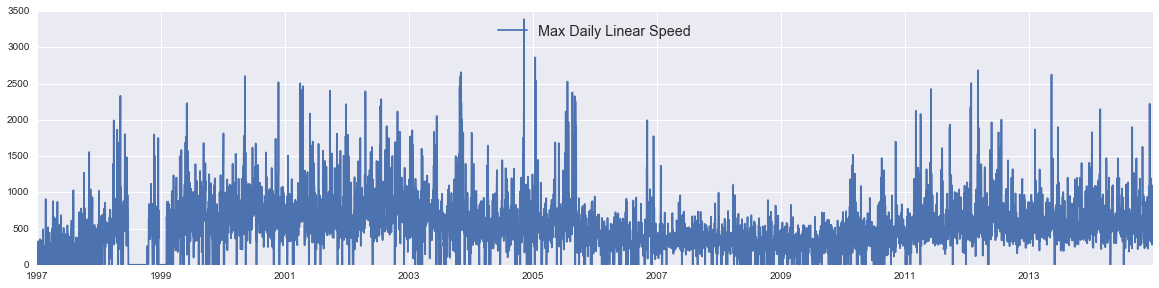

In [20]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.LinearSpeed_max, Label='Max Daily Linear Speed')
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.show()

plt.savefig('../images/LinearSpeed_max.png', bbox_inches='tight')

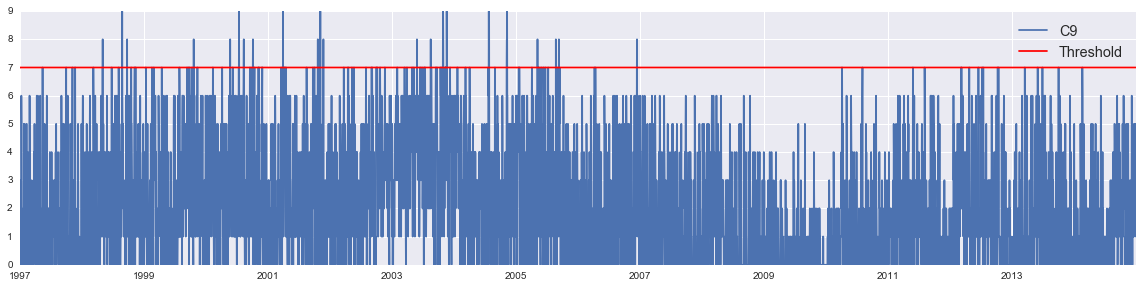

In [21]:
plt.figure(figsize=(20,10))
plt.subplot(212)
plt.plot(result.index, result['C9'], Label='C9')
a = np.empty(len(result.index))
a.fill(7)
plt.plot(result.index, a, Label = 'Threshold', color='red')
legend = plt.legend(loc='upper right', shadow=True, fontsize='large')

#plt.show()

plt.savefig('../images/C9.png', bbox_inches='tight')

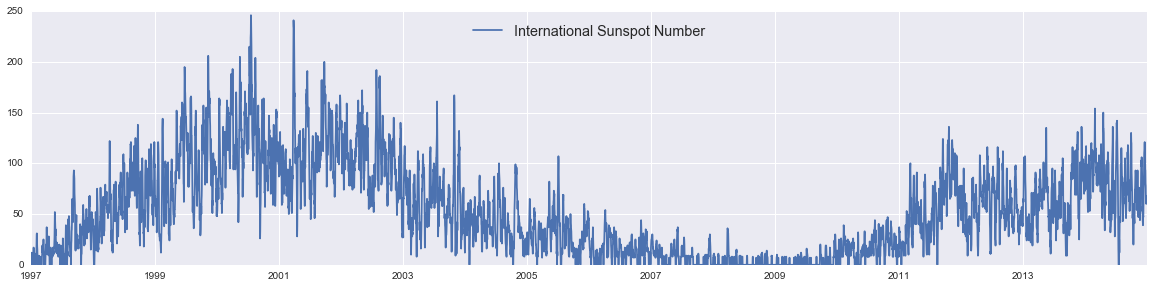

In [22]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result['ISN'], Label="International Sunspot Number")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.show()

plt.savefig('../images/ISN.png', bbox_inches='tight')

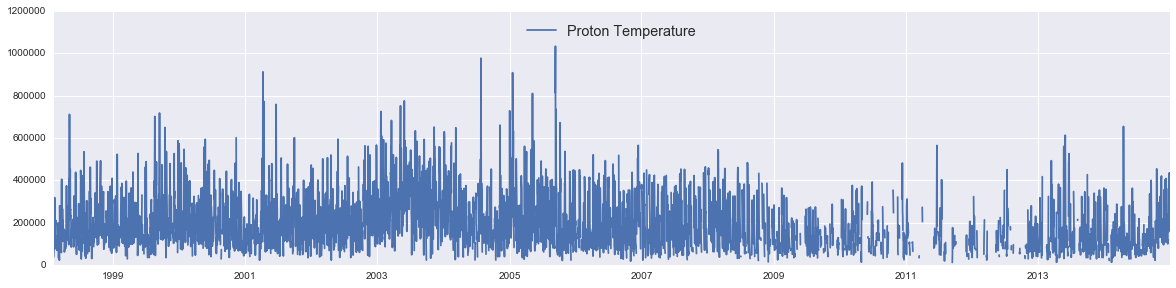

In [23]:
plt.figure(figsize=(20,10))

plt.subplot(212)
plt.plot(result.index, result['Proton_temp'], Label="Proton Temperature")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.show()

plt.savefig('../images/Proton_temp.png', bbox_inches='tight')

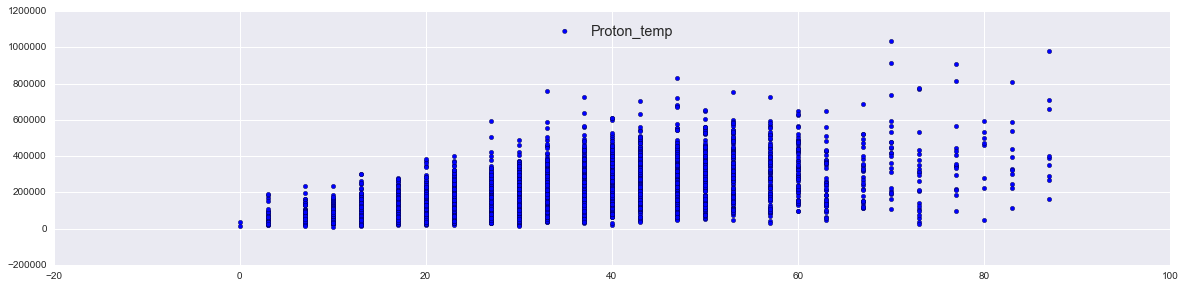

In [24]:
plt.figure(figsize=(20,10))

plt.subplot(212)
plt.scatter(result.Kp_max, result['Proton_temp'])
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.show()

plt.savefig('../images/Kp_max_Proton_temp.png', bbox_inches='tight')

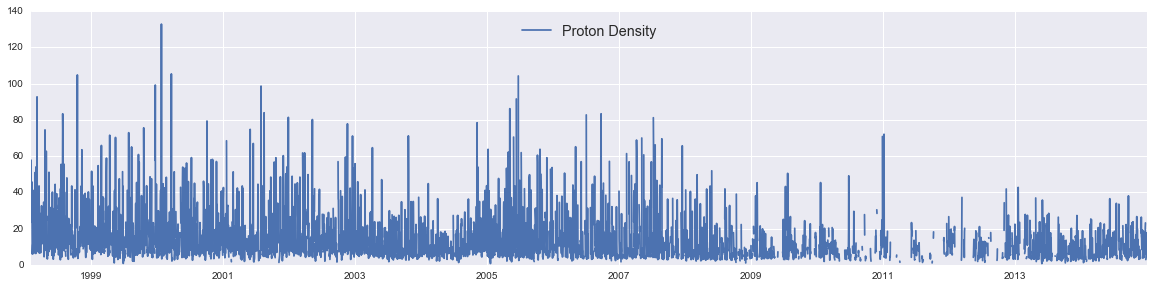

In [25]:
plt.figure(figsize=(20,10))

plt.subplot(212)
plt.plot(result.index, result['Proton_density'], Label="Proton Density")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.show()

plt.savefig('../images/Proton_density.png', bbox_inches='tight')

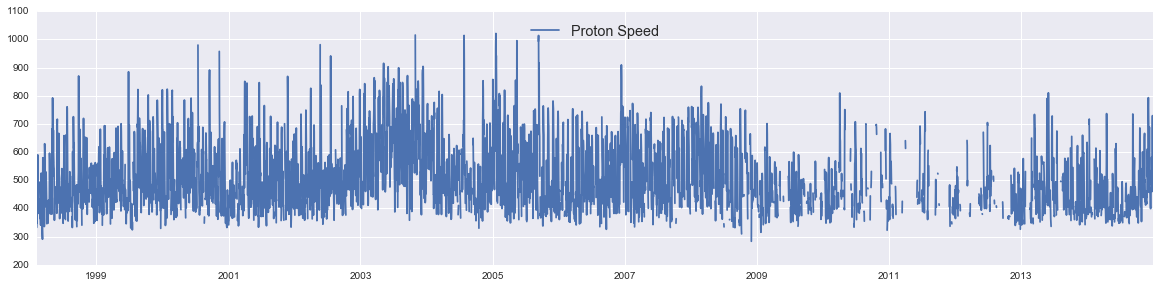

In [26]:
plt.figure(figsize=(20,10))

plt.subplot(212)
plt.plot(result.index, result['proton_speed'], Label="Proton Speed")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.show()

plt.savefig('../images/Proton_speed.png', bbox_inches='tight')

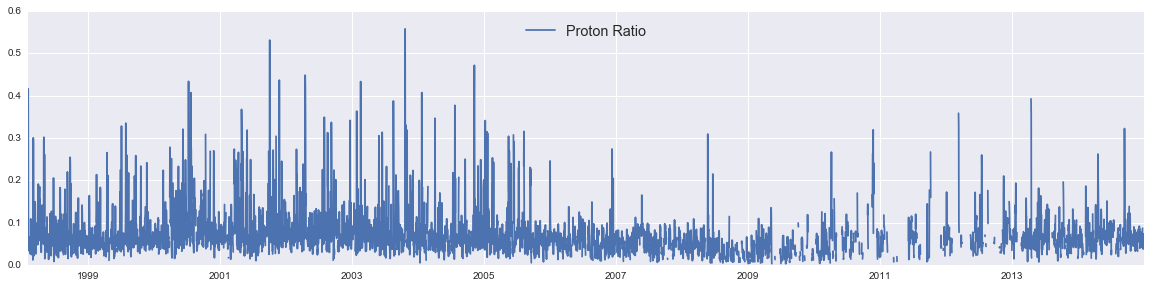

In [27]:
#
plt.figure(figsize=(20,10))

plt.subplot(212)
plt.plot(result.index, result['He4toprotons'], Label="Proton Ratio")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.show()

plt.savefig('../images/Proton_ratio.png', bbox_inches='tight')

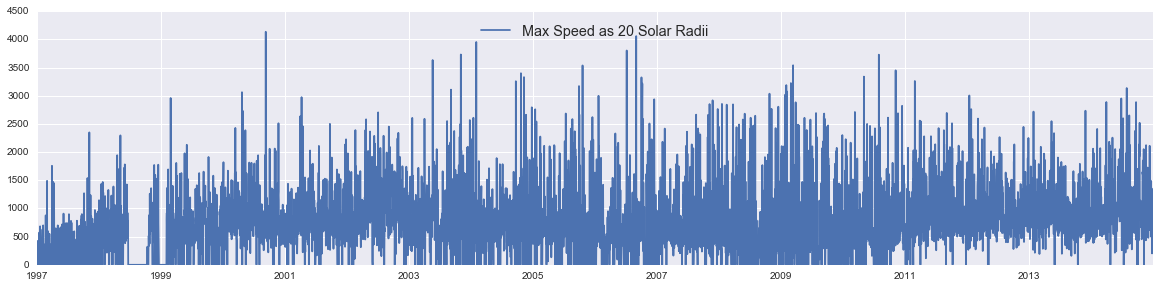

In [28]:
plt.figure(figsize=(20,10))

plt.subplot(212)
plt.plot(result.index, result['20R_max'], Label="Max Speed as 20 Solar Radii")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.show()

plt.savefig('../images/20R_max.png', bbox_inches='tight')

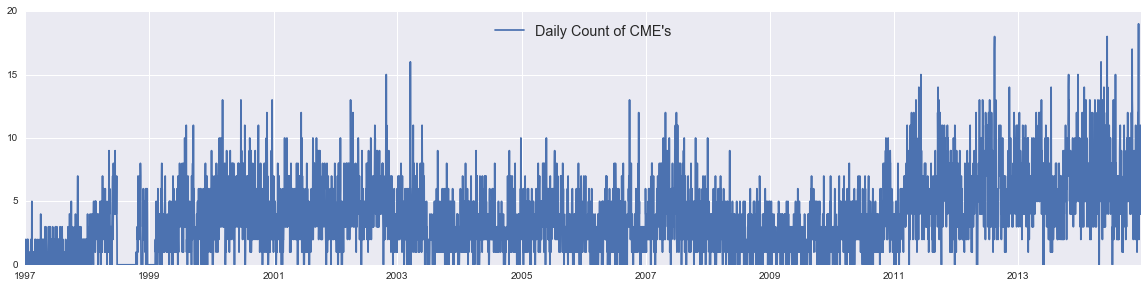

In [29]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result['CME_daily_count'], Label="Daily Count of CME's")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.show()

plt.savefig('../images/DailyCountCMEs.png', bbox_inches='tight')

feature_cols = ['LinearSpeed_max']
X = result[feature_cols]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

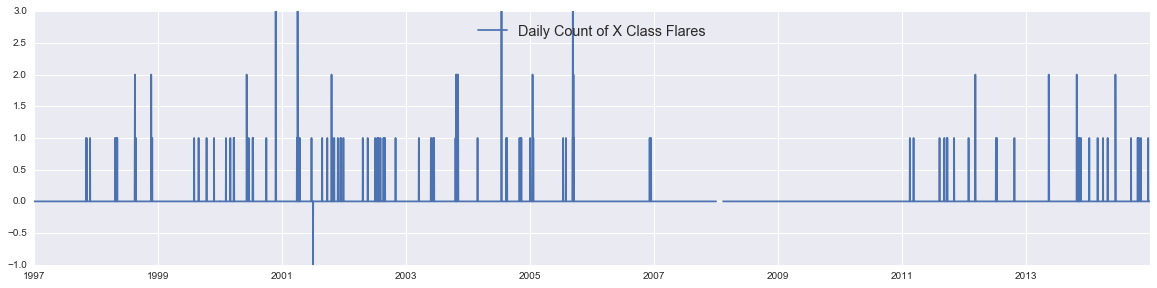

In [30]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result['X'], Label="Daily Count of X Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
#plt.show()

plt.savefig('../images/X_Flares.png', bbox_inches='tight')

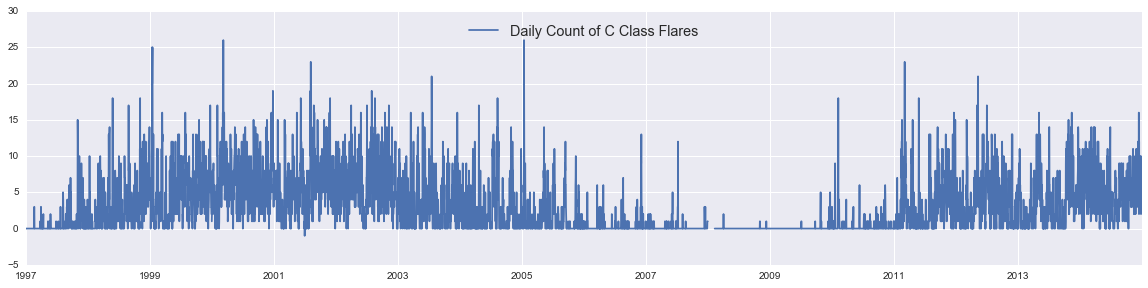

In [31]:
plt.figure(figsize=(20,10))
plt.subplot(212)
plt.plot(result.index, result['C'], Label="Daily Count of C Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
plt.savefig('../images/C_Flares.png', bbox_inches='tight')

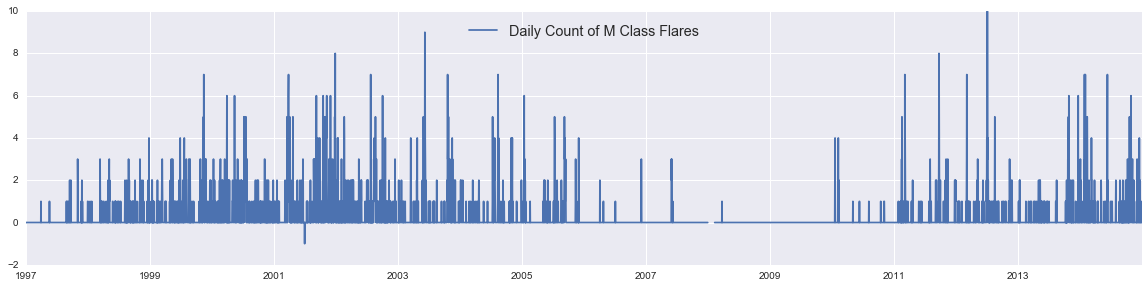

In [32]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result['M'], Label="Daily Count of M Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
plt.savefig('../images/M_Flares.png', bbox_inches='tight')

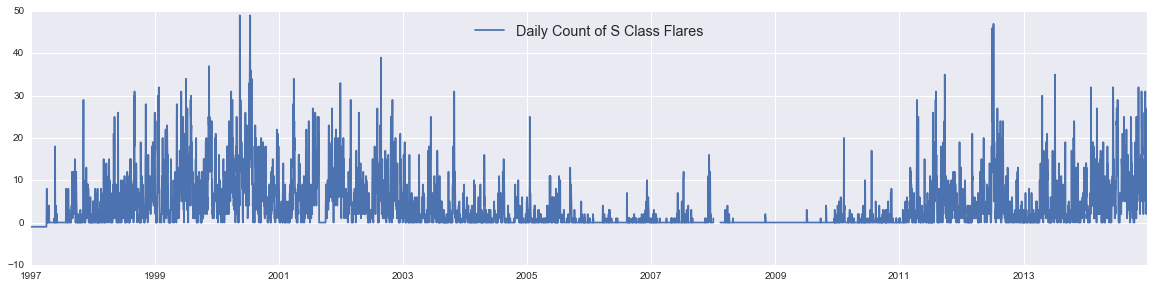

In [33]:
plt.figure(figsize=(20,10))
plt.subplot(212)
plt.plot(result.index, result['S'], Label="Daily Count of S Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.savefig('../images/S_Flares.png', bbox_inches='tight')

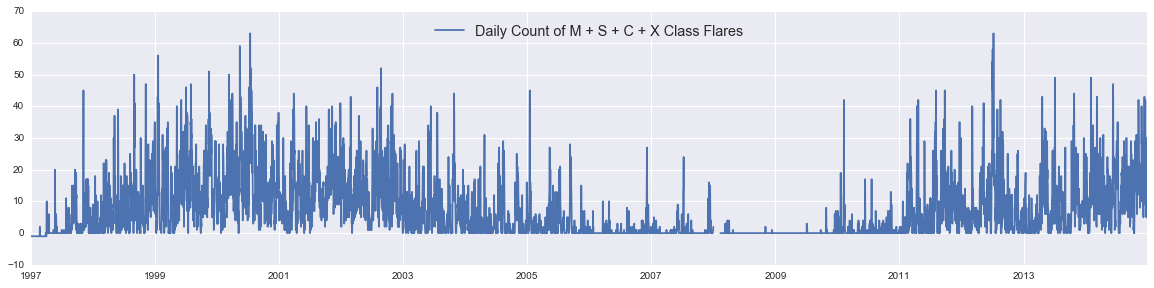

In [34]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.M + result.S + result.C + result.X, Label="Daily Count of M + S + C + X Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.savefig('../images/S_C_M_X_Flares.png', bbox_inches='tight')

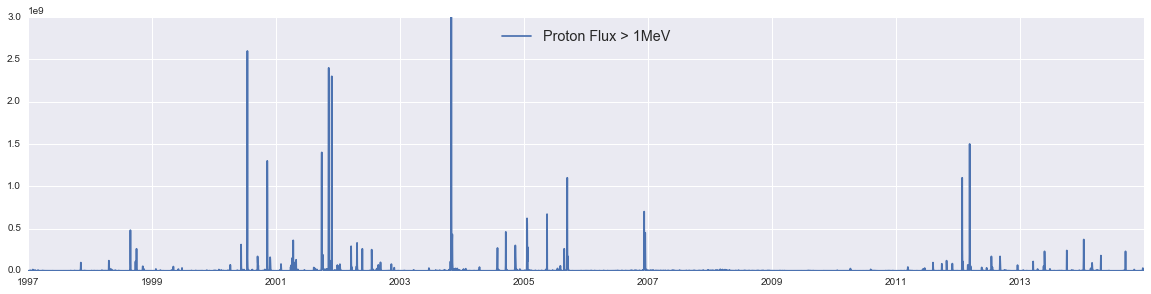

In [35]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.P1MeV, Label="Proton Flux > 1MeV")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.savefig('../images/Proton1MeV.png', bbox_inches='tight')

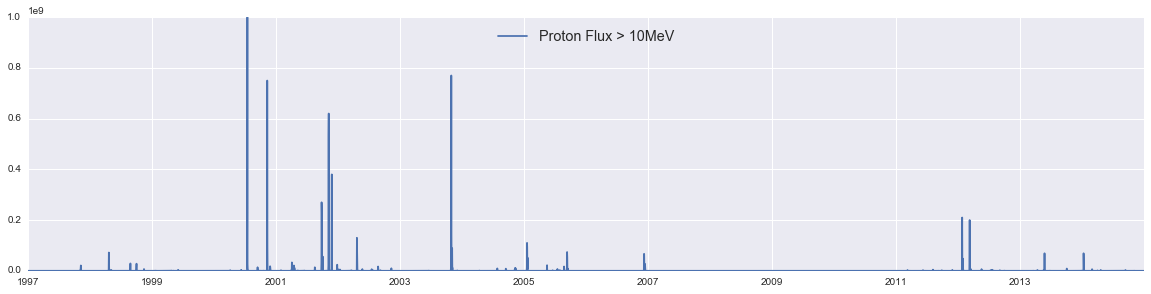

In [36]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.P10MeV, Label="Proton Flux > 10MeV")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.savefig('../images/Proton10MeV.png', bbox_inches='tight')

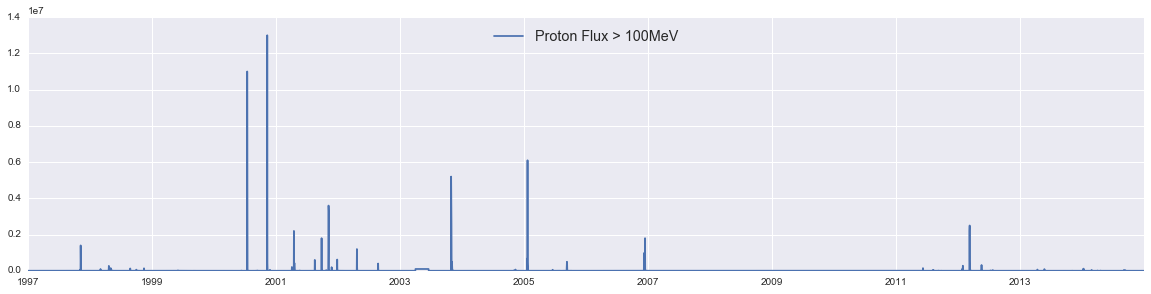

In [37]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.P100MeV, Label="Proton Flux > 100MeV")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.savefig('../images/Proton100MeV.png', bbox_inches='tight')

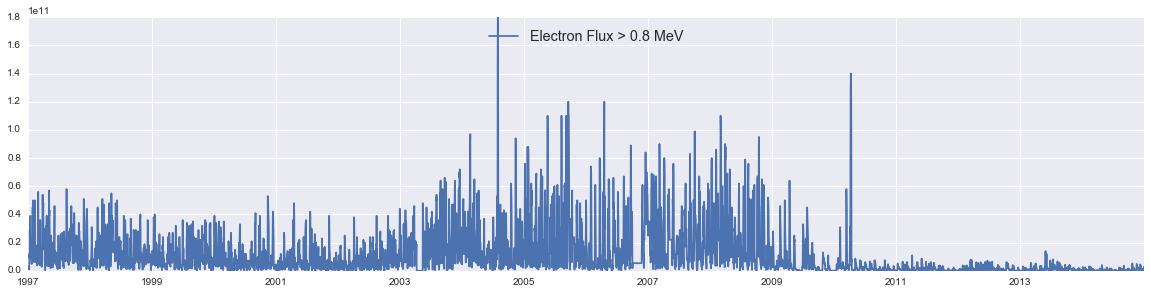

In [38]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.E08MeV, Label="Electron Flux > 0.8 MeV")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.savefig('../images/Electron0_8MeV.png', bbox_inches='tight')

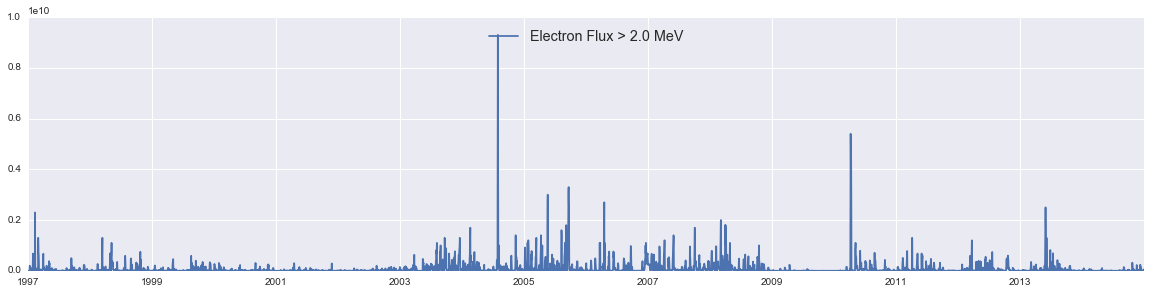

In [39]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.E2MeV, Label="Electron Flux > 2.0 MeV")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.savefig('../images/Electron20MeV.png', bbox_inches='tight')

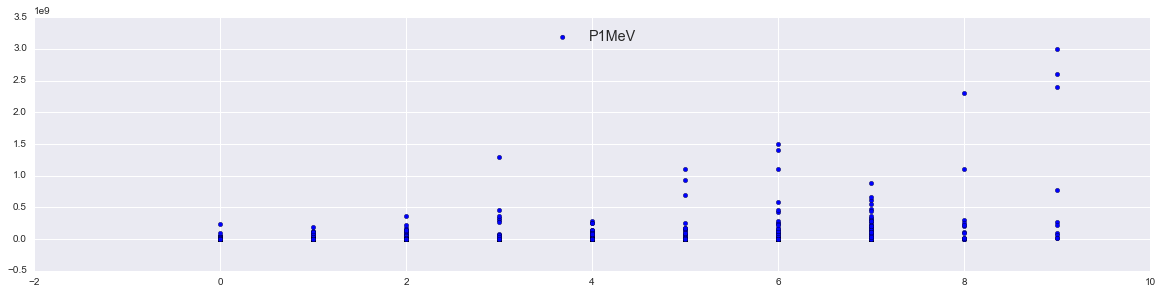

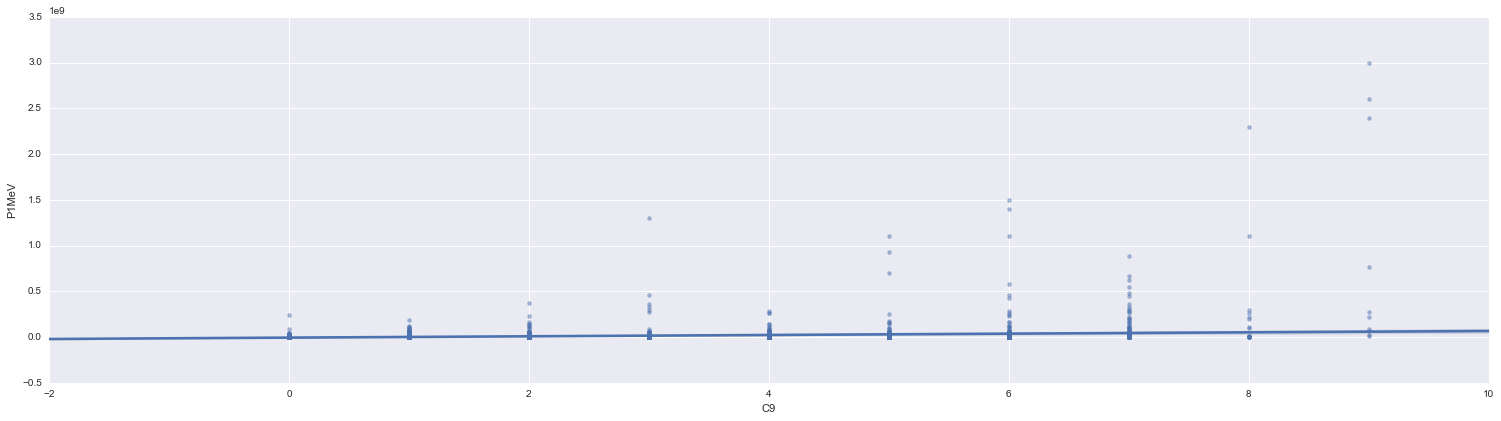

In [40]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.scatter( result.C9,result.P1MeV)
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.savefig('../images/Electron20MeV.png', bbox_inches='tight')

sns.lmplot(y='P1MeV', x='C9', data=result, aspect=3.5, scatter_kws={'alpha':0.5}, size=6)

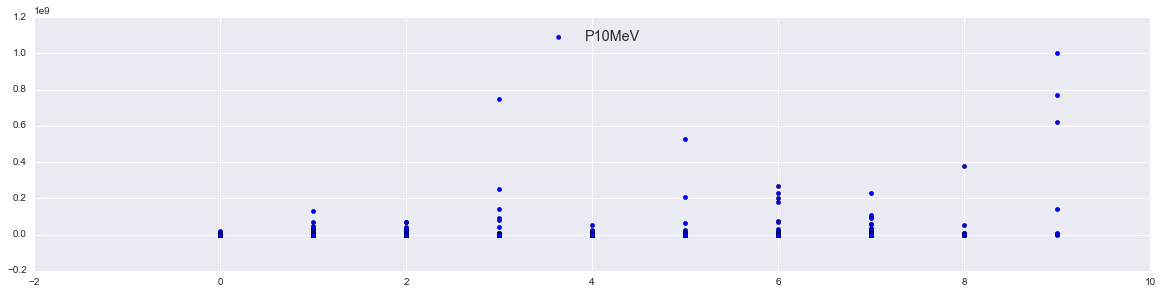

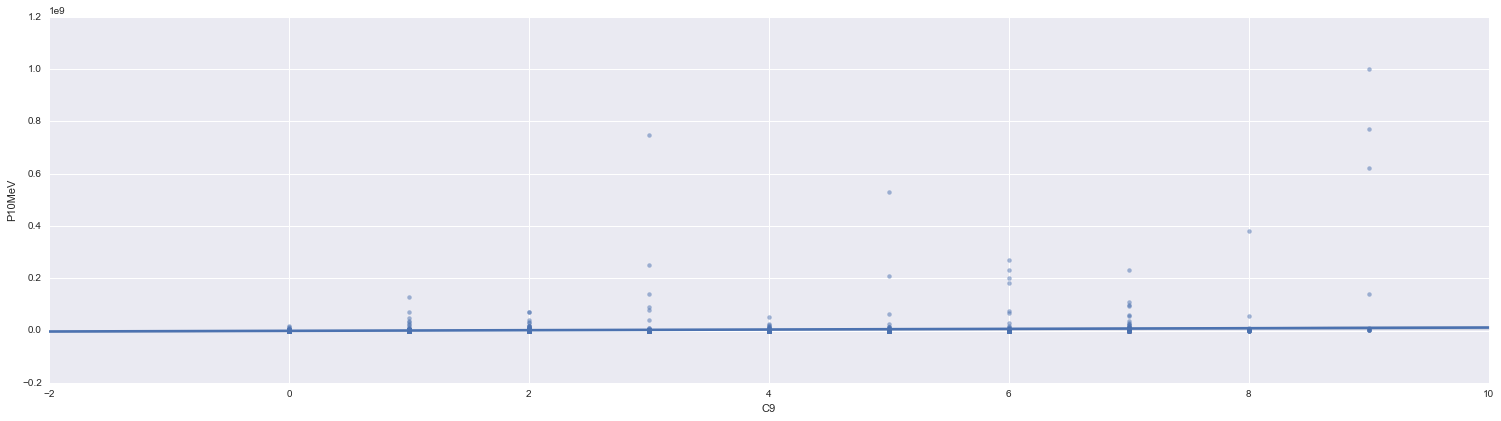

In [41]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.scatter( result.C9,result.P10MeV)
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.savefig('../images/Electron20MeV.png', bbox_inches='tight')

sns.lmplot(y='P10MeV', x='C9', data=result, aspect=3.5, scatter_kws={'alpha':0.5}, size=6)

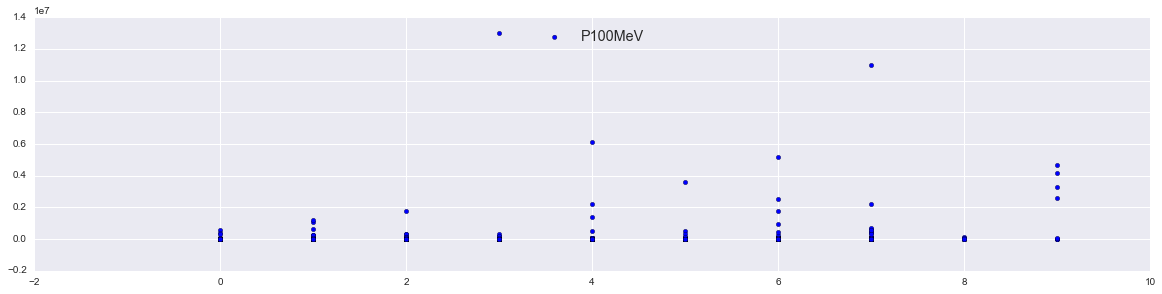

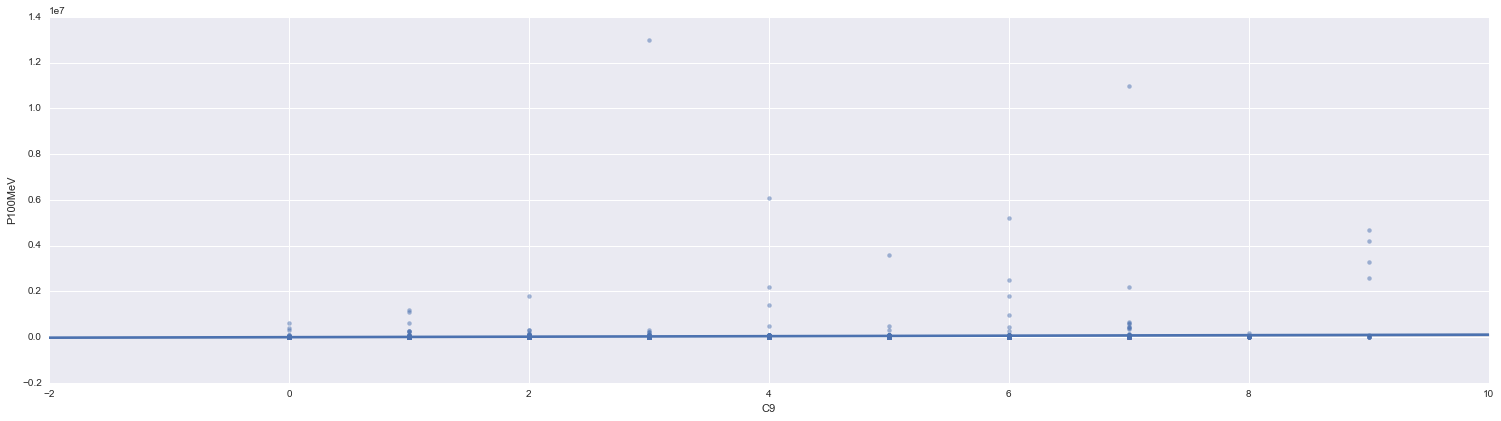

In [42]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.scatter( result.C9,result.P100MeV)
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.savefig('../images/Electron20MeV.png', bbox_inches='tight')

sns.lmplot(y='P100MeV', x='C9', data=result, aspect=3.5, scatter_kws={'alpha':0.5}, size=6)

In [43]:
result.groupby('C9').median()

Year  Month   Day  Bartels  BDay   Kp0   Kp3   Kp6   Kp9  Kp12   ...    \
C9                                                                     ...     
0   2008.0    7.0  16.0   2390.5  14.0   7.0   3.0   3.0   3.0   7.0   ...     
1   2006.0    6.0  16.0   2358.5  13.5  17.0  13.0  13.0  13.0  13.0   ...     
2   2005.0    6.0  16.0   2342.0  14.0  23.0  20.0  17.0  17.0  20.0   ...     
3   2004.0    6.0  16.0   2331.0  14.0  27.0  27.0  23.0  20.0  23.0   ...     
4   2004.0    7.0  15.0   2326.5  13.0  30.0  30.0  27.0  27.0  30.0   ...     
5   2003.0    6.0  16.0   2321.0  14.0  33.0  33.0  33.0  33.0  33.0   ...     
6   2003.0    7.0  15.0   2318.0  13.5  40.0  40.0  40.0  37.0  40.0   ...     
7   2002.0    7.0  14.0   2310.5  15.0  43.0  50.0  50.0  50.0  50.0   ...     
8   2003.0    9.0  18.0   2318.0  16.0  60.0  70.0  73.0  63.0  70.0   ...     
9   2003.0    9.0  26.0   2323.5  10.5  73.5  75.0  71.5  65.0  73.0   ...     

          E08MeV       E2MeV  Proton_density  Proton_temp  He4toprotons  \
C9                                                                        
0   4.100000e+09   9300000.0         7.11510      89933.0      0.049169   
1   4.900000e+09   9900000.0         8.49940     133340.0      0.060662   
2   6.000000e+09  12000000.0         9.01965     171275.0      0.062398   
3   6.200000e+09  12000000.0        10.10700     209540.0      0.063899   
4   7.750000e+09  14000000.0        10.02650     259790.0      0.062152   
5   6.450000e+09  14000000.0        11.53450     304790.0      0.062439   
6   6.150000e+09  13000000.0        12.60450     332915.0      0.063146   
7   2.950000e+09   7700000.0        19.13950     324030.0      0.105070   
8   2.600000e+09   6300000.0        23.83200     400430.0      0.176310   
9   5.350000e+09  18000000.0        26.75650     424355.0      0.153030   

    proton_speed  LinearSpeed_max  20R_max  CME_daily_count  Kp_max  
C9                                                                   
0        411.940            406.0    624.5              3.0    13.0  
1        451.870            474.0    699.0              3.0    23.0  
2        488.805            485.0    695.0              4.0    30.0  
3        523.410            515.5    676.0              3.0    37.0  
4        579.605            507.0    659.5              3.0    40.0  
5        607.825            546.5    710.5              3.0    47.0  
6        642.325            579.0    738.0              3.0    53.0  
7        639.230            614.0    800.0              4.0    67.0  
8        792.170            797.0    919.0              4.0    83.0  
9        772.215            576.5    713.0              2.0    87.0  

[10 rows x 51 columns]

Remove columns not used in the analysis

In [44]:
result.drop(['Year', 'Month', 'Day', 'Bartels','BDay','Kp0','Kp3','Kp6','Kp9','Kp12','Kp15','Kp18','Kp21'], axis=1, inplace=True)

In [45]:
result.shape

(6574, 40)

In [46]:
dt = result.index
# create a new list of dates shifted back in time by one week so that we can summarize solar activity over the past week
dt_shifted = dt.shift(-2,'D')
# For each event in the extreme events collection, summarize activity over the prior period (a week)
first_event = True
for event in dt:
    dt_range = pd.date_range(event, periods=3, freq='D')
    # create a dataframe with the information within this date range
    event_results = result.loc[dt_range]
    # create summary values that we'll append to the result set later
    C_sum = event_results.C.sum()
    M_sum = event_results.M.sum()
    X_sum = event_results.X.sum()
    S_sum = event_results.S.sum()
    ISN_sum =event_results.ISN.sum()
    Opt1_sum = event_results.Opt1.sum()
    Opt2_sum = event_results.Opt2.sum()
    Opt3_sum = event_results.Opt3.sum()
    CME_daily_count_sum = event_results.CME_daily_count.sum()
    LinearSpeed_max = event_results.LinearSpeed_max.max()
    TwentyR_max = event_results['20R_max'].max()
    P1MeV_sum = event_results.P1MeV.sum()
    P10MeV_sum = event_results.P10MeV.sum()
    P100MeV_sum = event_results.P100MeV.sum()
    Proton_temp_sum = event_results.Proton_temp.sum()
    proton_speed_sum = event_results.proton_speed.sum()
    Proton_density_sum = event_results.Proton_density.sum()
    He4toprotons_sum = event_results.He4toprotons.sum()
    
    # turn these values into a dictionary object that will turn into a dataframe and merge with the result set
    event_dict =  {'Date': event, 'C_sum' : C_sum, 'M_sum' : M_sum, 'X_sum': X_sum, 'S_sum': S_sum, 'ISN_sum': ISN_sum, 
                  'Opt1_sum': Opt1_sum, 'Opt2_sum': Opt2_sum,'Opt3_sum': Opt3_sum, 
                  'CME_daily_count_sum': CME_daily_count_sum, 'LinearSpeed_max_max': LinearSpeed_max, '20R_max_max' : TwentyR_max,
                  'P1MeV_sum' : P1MeV_sum, 'P10MeV_sum' : P10MeV_sum, 'P100MeV_sum' : P100MeV_sum, 'Proton_temp_sum' : Proton_temp_sum,
                  'proton_speed_sum' : proton_speed_sum, 'Proton_density_sum' : Proton_density_sum, 'He4toprotons_sum' : He4toprotons_sum}
    event_df = pd.DataFrame(event_dict, index=['Date'])
    event_df.index = event_df.Date
  
    if first_event:
        result = pd.concat([result, event_df], axis=1)
        first_event = False
        
    else:
        result.loc[event_df.Date, ['C_sum', 'M_sum', 'M_sum', 'X_sum', 'S_sum', 'ISN_sum', 'Opt1_sum', 'Opt2_sum',
                                             'Opt3_sum', 'CME_daily_count_sum', 'LinearSpeed_max_max', '20R_max_max', 
                                               'P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum', 'Proton_temp_sum', 'proton_speed_sum',
                                              'Proton_density_sum', 'He4toprotons_sum']] = event_df[['C_sum', 'M_sum', 'M_sum', 'X_sum',
                                             'S_sum', 'ISN_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 'CME_daily_count_sum', 'LinearSpeed_max_max',
                                            '20R_max_max', 'P1MeV_sum', 'P10MeV_sum','P100MeV_sum', 'Proton_temp_sum', 'proton_speed_sum',
                                              'Proton_density_sum', 'He4toprotons_sum']]
result.drop(['Date'], axis=1, inplace=True)
result.shape

(6574, 58)

Create a response variable for logistic regression y=1 when C9 >=8, y=0 otherwise

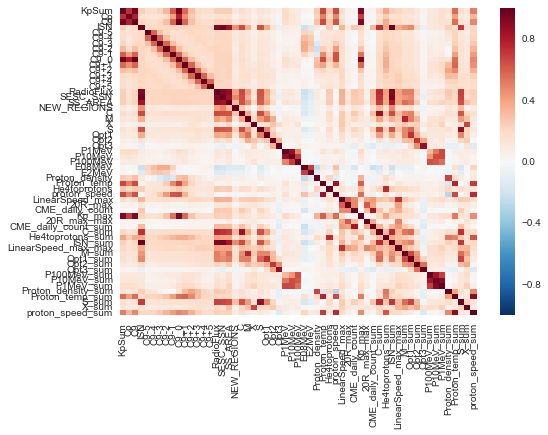

In [47]:
sns.heatmap(result.corr())  
plt.savefig('../images/CoorHeatmap.png', bbox_inches='tight')

**Run Linear and Logistic Regression Models as well as ROC curves feature combinations**

On 5/17/16 combined the code to run cummulative features as well.

In [48]:
#result['y']=(result.C9>=6).map({True:1, False:0}); feature_col_suffix = 'mean'; ; str_threshold = 'C9 >= 6'; ; str_response = 'C9'
result['y']=(result.Kp_max>=60).map({True:1, False:0}); feature_col_suffix = 'max'; str_threshold = 'Kp_max >= 60'; str_response = 'Kp_max'
result['Proton_temp_inv'] = 1/result.Proton_temp

In [49]:
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

feature_columns = [['Proton_temp'], ['Proton_temp_inv'], ['Proton_density'], ['He4toprotons'], ['proton_speed'], ['Proton_temp', 'proton_speed'],
                  ['C9-1'], ['C9+1'], ['RadioFlux'], ['Proton_temp_inv', 'C9-1'], [ 'P10MeV', 'P100MeV'], ['P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum'],
                  ['Proton_temp_sum'], ['proton_speed_sum'], ['Proton_temp_sum', 'proton_speed_sum'], ['Proton_density_sum']]
logreg = LogisticRegression()
linreg = LinearRegression()

for feature_cols in feature_columns:
    print feature_cols
    result_no_nan = result[(result[feature_cols[0]].isnull()==False)]
    if len(feature_cols) > 1:
        for i in range(1, len(feature_cols)):
            result_no_nan = result_no_nan[(result_no_nan[feature_cols[i]].isnull()==False)]
    X = result_no_nan[feature_cols]
    y = result_no_nan.y
    y1 = result_no_nan[str_response]
    logreg.fit(X, y)
    linreg.fit(X, y1)
    b = linreg.intercept_
    m = linreg.coef_
    
    result_no_nan['y_pred_class'] = logreg.predict(X)
    result_no_nan['y_pred'] = linreg.predict(X)
    
    rmse = np.sqrt(metrics.mean_squared_error(y1, result_no_nan['y_pred']))
    print 'rmse=' + rmse.astype(str)
    
    y_null = np.zeros_like(y1, dtype=float)
    y_null.fill(y1.mean())
    rmse_null = np.sqrt(metrics.mean_squared_error(y_null, result_no_nan['y_pred']))
    
    print 'rmse_null=' + rmse_null.astype(str)
    
    str_feature_cols = ''
    str_feature_cols_no_suffix = ''
    for i in range(0, len(feature_cols)):
        str_feature_cols = str_feature_cols + feature_cols[i] + '_' + feature_col_suffix
        str_feature_cols_no_suffix = str_feature_cols_no_suffix + feature_cols[i]
        
    sns.pairplot(result_no_nan, x_vars=feature_cols, y_vars=str_response, kind='reg', aspect=4.5)    

    if len(feature_cols) == 1:
        print 'scatter'
        # Scatter plot of features and response class
        plt.subplot(211)
        plt.xlabel(str_feature_cols + ' (daily' + feature_col_suffix + ')')
        plt.ylabel(str_threshold)
        plt.scatter(X, y)
        
        legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
        
        # Scatter Plot of predicted class vs feature
        plt.subplot(212)
        plt.xlabel(str_feature_cols + ' (daily' + feature_col_suffix + ')')
        plt.ylabel(str_threshold)
        plt.scatter(X, result_no_nan.y_pred_class, color='red')
        legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
        
        plt.savefig('../images/LogReg_' + str_response + '_' + str_feature_cols + '.png', bbox_inches='tight')
        
        plt.clf()

        # Scatter plot of features and response variable
        plt.figure(figsize=(20,10))
        plt.subplot(211)
        plt.xlabel(str_feature_cols + ' (daily' + feature_col_suffix + ')')
        plt.ylabel(str_response)
        plt.scatter(X, result_no_nan[[str_response]])
        # Plot the regression line
        plt.plot(pd.Series(X.values.ravel()).unique(), m * pd.Series(X.values.ravel()).unique() + b, color='r')
        plt.title('Linear Regression ' + str_response + ' vs. ' + str_feature_cols)
        footnote_text = 'RMSE = ' + rmse.astype(str) + ' : RMSE (null) = ' + rmse_null.astype(str)
        plt.figtext(0.2, 0.91, footnote_text, horizontalalignment='center') 
        
        #legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
        
        plt.savefig('../images/LinReg'+ str_response + '_' + str_feature_cols + '.png', bbox_inches='tight')
        plt.clf()
    
    print 'roc'
    plt.clf()
    y_pred_prob = logreg.predict_proba(X)[:, 1]
    plt.rcParams['figure.figsize'] = (16, 6)
    plt.rcParams['font.size'] = 14
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve for '+ str_feature_cols +' to Predict ' + str_threshold)
    #print metrics.roc_auc_score(y, y_pred_prob)
    plt.savefig('../images/ROC_' + str_response + '_' + str_feature_cols + '.png', bbox_inches='tight')
    plt.clf()
     
    #print logreg.score(X, result_no_nan.y)
    #print metrics.accuracy_score(y, result_no_nan.y_pred_class)
         

C:\Users\xwhx\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\xwhx\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['Proton_temp']
rmse=11.4185724117
rmse_null=8.52987205034
scatter
roc
['Proton_temp_inv']
rmse=12.7055704007
rmse_null=6.4584049044
scatter
roc
['Proton_density']
rmse=13.3143626385
rmse_null=5.08628161308
scatter
roc
['He4toprotons']
rmse=13.5740977052
rmse_null=4.3458468229
scatter
roc
['proton_speed']
rmse=11.7165171872
rmse_null=8.11577095044
scatter
roc
['Proton_temp', 'proton_speed']
rmse=11.2952759729
rmse_null=8.69248260361
roc
['C9-1']
rmse=12.3114567423
rmse_null=7.94017477792
scatter
roc
['C9+1']
rmse=12.0271711193
rmse_null=8.36529427756
scatter
roc
['RadioFlux']
rmse=14.2352391514
rmse_null=3.45079651692
scatter
roc
['Proton_temp_inv', 'C9-1']
rmse=11.6686598292
rmse_null=8.18442978508
roc
['P10MeV', 'P100MeV']
rmse=14.5316264702
rmse_null=1.85252157564
roc
['P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum']
rmse=14.3118268796
rmse_null=3.12595832119
roc
['Proton_temp_sum']
rmse=12.4888792943
rmse_null=7.6568856614
scatter
roc
['proton_speed_sum']
rmse=12.9292105823
rmse_null=6.88

C:\Users\xwhx\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


**K-Means Clustering of Features**

5/17/16 This code will also handle cummulative features

In [79]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
colors = np.array(['red', 'green', 'blue', 'yellow', 'purple', 'black', 'pink', 'beige', 'brown', 'coral', 'darkgray', 'gold', 'olive'])

#feature_cols = [ 'Proton_temp', 'proton_speed', 'E2MeV', 'P10MeV']
#feature_cols = ['P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum']
feature_cols = ['Proton_temp_sum']

result_no_nan = result[(result[feature_cols[0]].isnull()==False)]
if len(feature_cols) > 1:
    for i in range(1, len(feature_cols)):
        result_no_nan = result_no_nan[(result_no_nan[feature_cols[i]].isnull()==False)]

str_feature_cols_no_suffix = ''
str_feature_cols_list = ''
for i in range(0, len(feature_cols)):
    str_feature_cols_no_suffix = str_feature_cols_no_suffix + feature_cols[i]
    str_feature_cols_list = str_feature_cols_list + feature_cols[i] + ', '
str_feature_cols_list = str_feature_cols_list[0:len(str_feature_cols_list)-2]
    
X = result_no_nan[feature_cols]
X_scaled = scaler.fit_transform(X)

n = 4 # number of clusters

C:\Users\xwhx\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


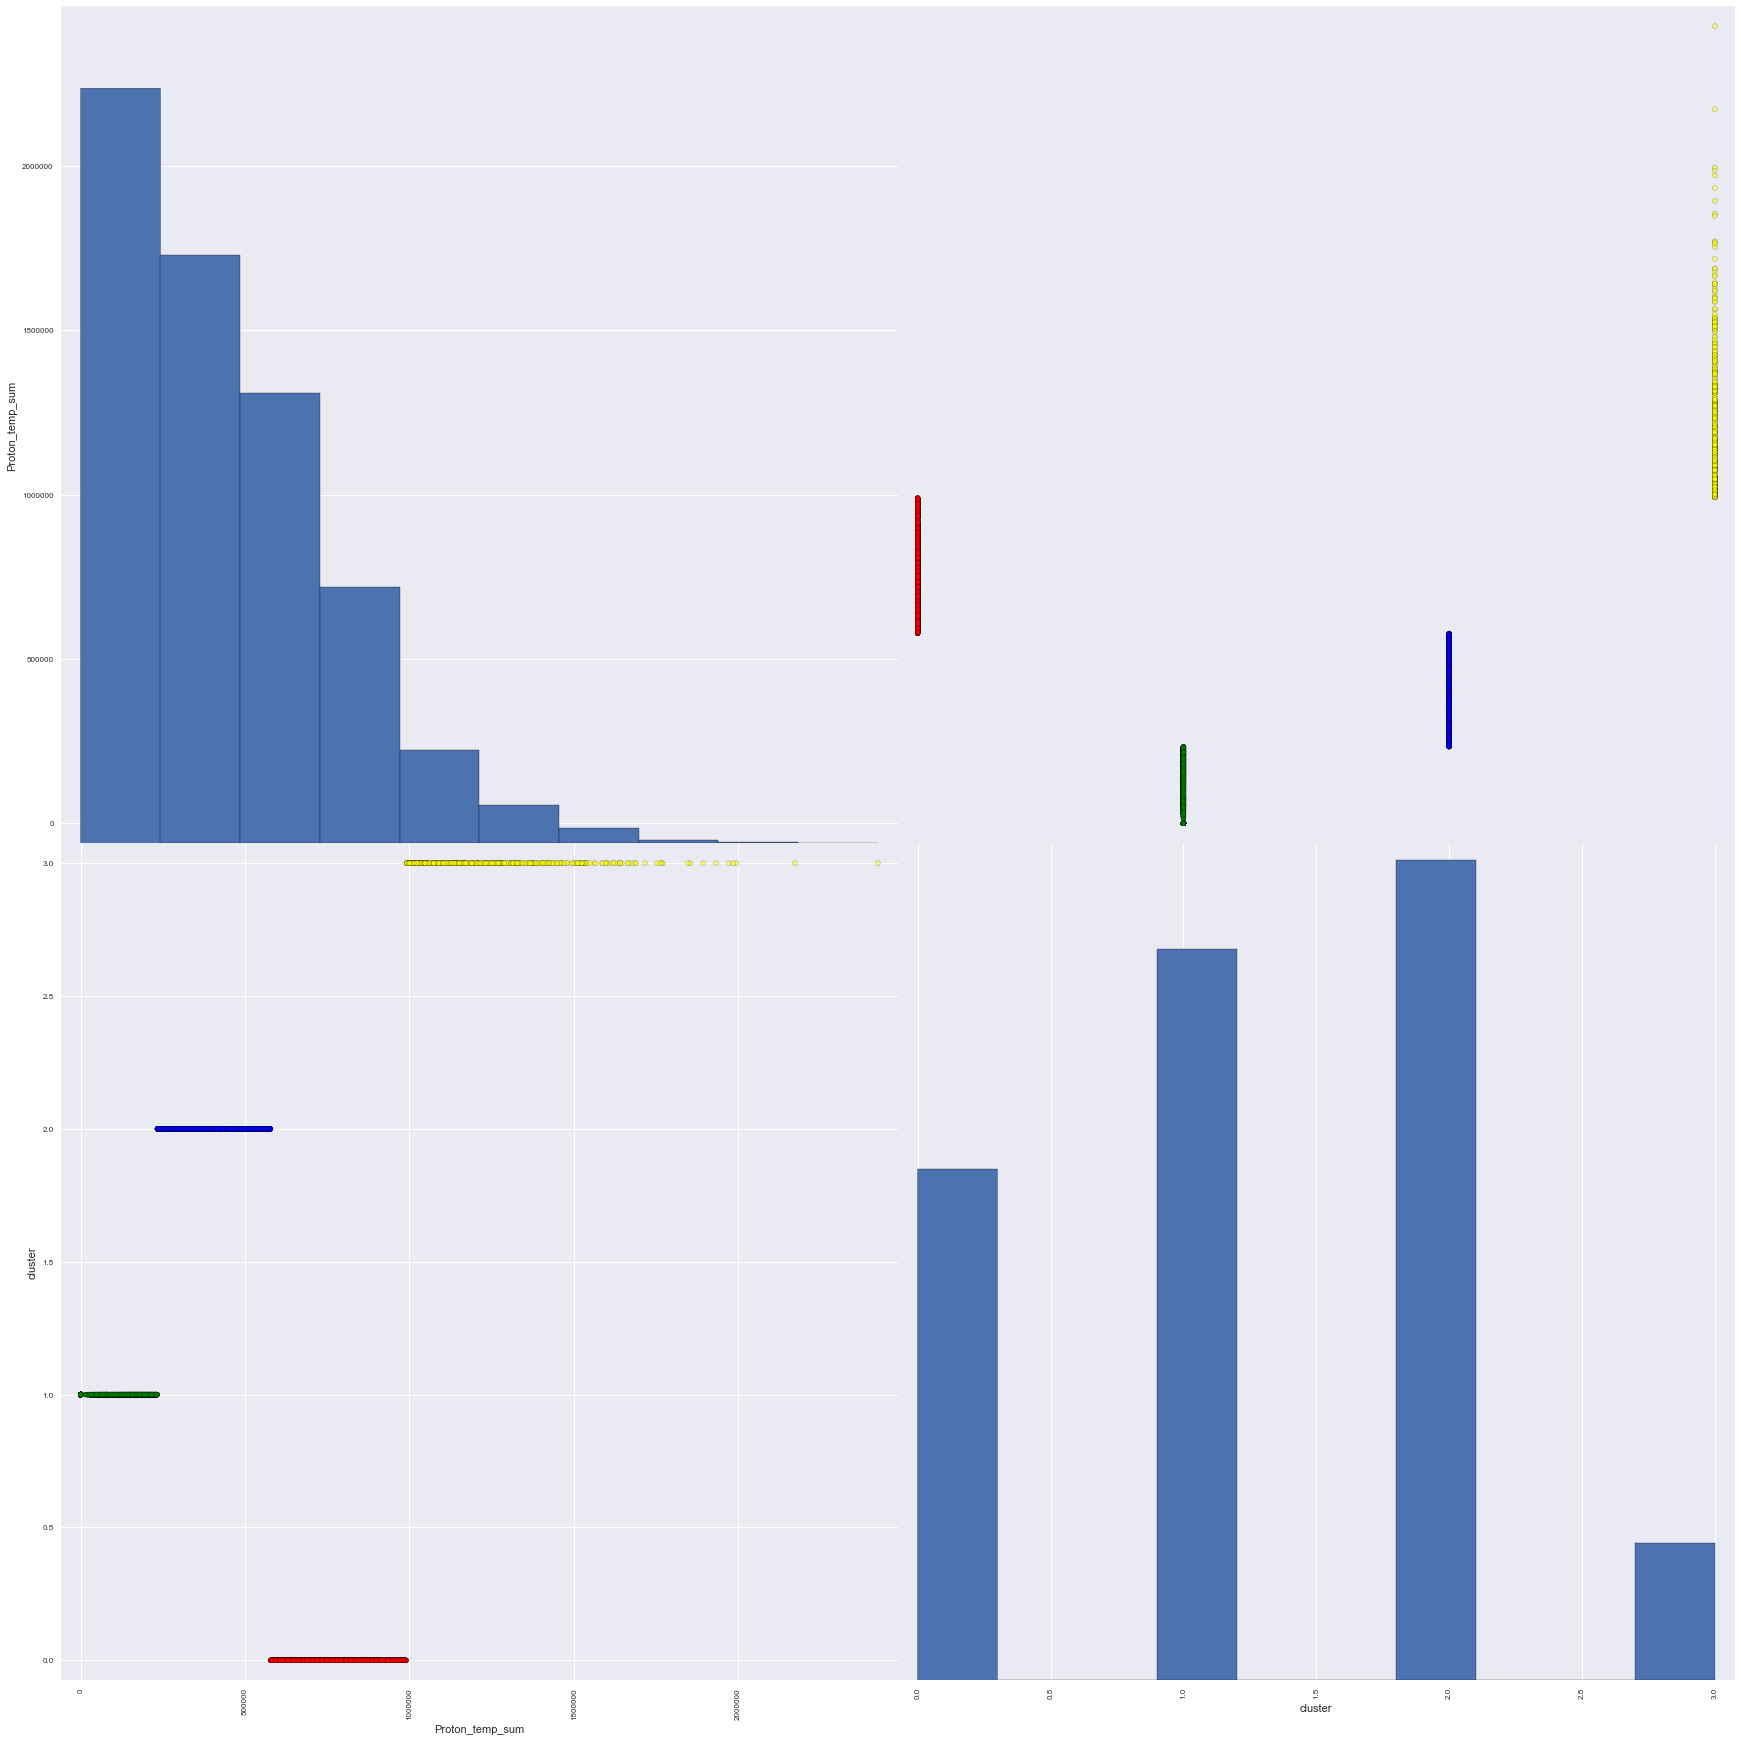

In [80]:
km = KMeans(n_clusters=n, random_state=1)
km.fit(X_scaled)

X['cluster'] = km.labels_
result_no_nan['cluster'] = km.labels_
scatter = pd.scatter_matrix(X, c=colors[X.cluster], figsize=(30,30), s=100)

plt.savefig('../images/Kmeans(n=' + str(n) + ')_simple_features_' +  str_feature_cols_no_suffix + '.png', bbox_inches='tight')

In [84]:
print result_no_nan.groupby('cluster').mean()

             KpSum        Cp        C9        ISN      C9-5      C9-4  \
cluster                                                                 
0        19.645056  0.273084  3.189260  60.229208  2.328094  2.323510   
1         9.520737  0.052632  1.007780  37.722654  1.468349  1.450252   
2        13.106079  0.079151  1.684619  60.480620  2.103631  2.134639   
3        26.956204  0.639903  4.829684  59.576642  3.065693  2.992701   

             C9-3      C9-2      C9-1      C9_0      ...         P10MeV_sum  \
cluster                                              ...                      
0        2.368697  2.519974  2.838245  3.189260      ...       6.143784e+06   
1        1.399175  1.282180  1.131410  1.007780      ...       3.169057e+06   
2        2.146879  2.133007  1.961240  1.684619      ...       3.391048e+06   
3        3.024331  3.175182  3.824818  4.829684      ...       4.583877e+06   

            P1MeV_sum  Proton_density_sum  Proton_temp_sum      S_sum  \
cluster      

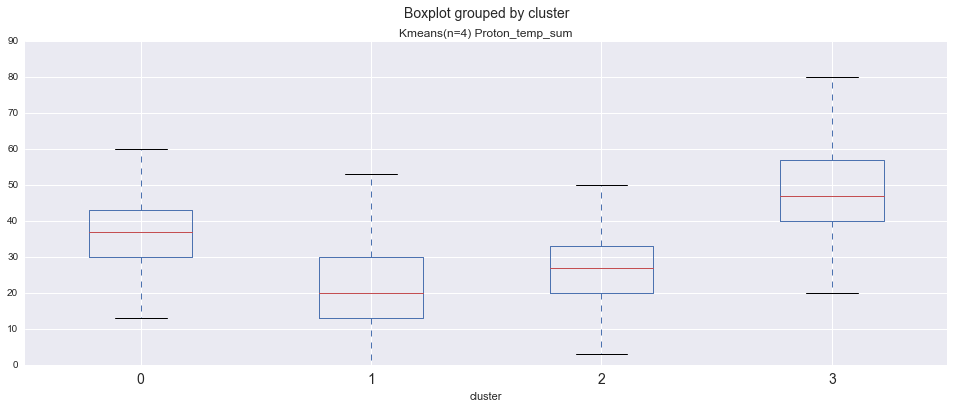

In [82]:
result_no_nan.boxplot(column='Kp_max', by='cluster')
plt.title('Kmeans(n=' + str(n) + ') ' +  str_feature_cols_list)
plt.savefig('../images/Kmeans(n=' + str(n) + ')_boxplot_' +  str_feature_cols_no_suffix + '.png', bbox_inches='tight')          

**Build a Predictive Model Using the Clustering Above**

Establish a threshold of Kp_max = 5 and a observed and predicted class and measure accuracy


In [83]:
result_no_nan.y = (result_no_nan.Kp_max > 60).map({False:0, True:1})
result_no_nan['y_pred_class'] = (result_no_nan.cluster == 3).map({False:0, True:1})
print metrics.accuracy_score(result_no_nan.y, result_no_nan.y_pred_class)

Kp_thresh = result_no_nan[(result_no_nan.Kp_max > 60)]
print metrics.accuracy_score(Kp_thresh.y, Kp_thresh.y_pred_class)

0.924094919379
0.263440860215


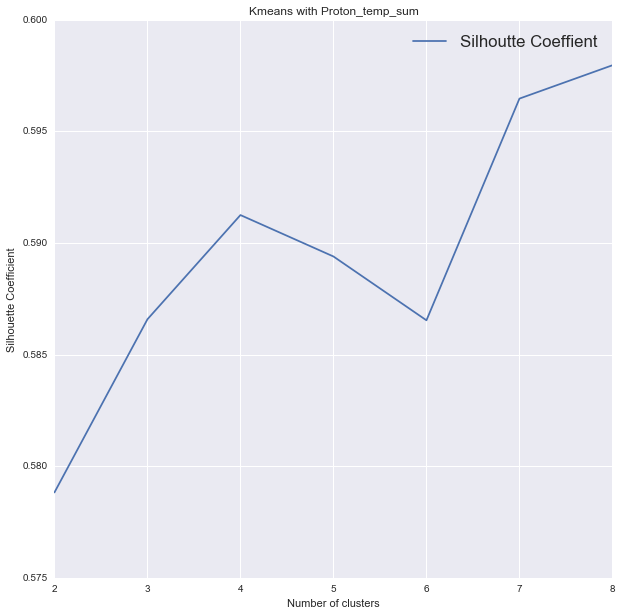

In [78]:
# calculate SC for K=2 through K=8
k_range = range(2, 9)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

# plot the results
plt.figure(figsize=(10,10))
plt.plot(k_range, scores, Label = "Silhoutte Coeffient")
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)
plt.title('Kmeans with ' + str_feature_cols_list)
legend = plt.legend(loc='upper right', shadow=True, fontsize='large')
plt.savefig('../images/Kmeans_Silhoutte_Coef_simple_features_' +  str_feature_cols_no_suffix + '.png', bbox_inches='tight')

**5/17/16 The remainder of this code has been deprecated**

This next part of the analysis is looking at the cumulative effects of solar activity


In [ ]:
# Get the dates of the extreme geomagnetic storms based on a C9 rating of 9.
# This is a collection of dates that we need to iteration through

results_filtered = result[result.C9 >= 0]
dt = results_filtered.index
dt

In [ ]:
# create a new list of dates shifted back in time by one week so that we can summarize solar activity over the past week
dt_shifted = dt.shift(-2,'D')

In [ ]:
# For each event in the extreme events collection, summarize activity over the prior period (a week)
first_event = True
for event in dt:
    dt_range = pd.date_range(event, periods=3, freq='D')
    # create a dataframe with the information within this date range
    event_results = result.loc[dt_range]
    # create summary values that we'll append to the result set later
    C_sum = event_results.C.sum()
    M_sum = event_results.M.sum()
    X_sum = event_results.X.sum()
    S_sum = event_results.S.sum()
    ISN_sum =event_results.ISN.sum()
    Opt1_sum = event_results.Opt1.sum()
    Opt2_sum = event_results.Opt2.sum()
    Opt3_sum = event_results.Opt3.sum()
    CME_daily_count_sum = event_results.CME_daily_count.sum()
    LinearSpeed_max = event_results.LinearSpeed_max.max()
    TwentyR_max = event_results['20R_max'].max()
    P1MeV_sum = event_results.P1MeV.sum()
    P10MeV_sum = event_results.P10MeV.sum()
    P100MeV_sum = event_results.P100MeV.sum()
    # turn these values into a dictionary object that will turn into a dataframe and merge with the result set
    event_dict =  {'Date': event, 'C_sum' : C_sum, 'M_sum' : M_sum, 'X_sum': X_sum, 'S_sum': S_sum, 'ISN_sum': ISN_sum, 
                  'Opt1_sum': Opt1_sum, 'Opt2_sum': Opt2_sum,'Opt3_sum': Opt3_sum, 
                  'CME_daily_count_sum': CME_daily_count_sum, 'LinearSpeed_max_max': LinearSpeed_max, '20R_max_max' : TwentyR_max,
                  'P1MeV_sum' : P1MeV_sum, 'P10MeV_sum' : P10MeV_sum, 'P100MeV_sum' : P100MeV_sum}
    event_df = pd.DataFrame(event_dict, index=['Date'])
    event_df.index = event_df.Date
  
    if first_event:
        results_filtered = pd.concat([results_filtered, event_df], axis=1)
        first_event = False
        
    else:
        results_filtered.loc[event_df.Date, ['C_sum', 'M_sum', 'M_sum', 'X_sum', 'S_sum', 'ISN_sum', 'Opt1_sum', 'Opt2_sum',
                                             'Opt3_sum', 'CME_daily_count_sum', 'LinearSpeed_max_max', '20R_max_max', 'P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum']] = event_df[['C_sum', 'M_sum', 'M_sum', 'X_sum',
                                             'S_sum', 'ISN_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 'CME_daily_count_sum', 'LinearSpeed_max_max',
                                            '20R_max_max', 'P1MeV_sum', 'P10MeV_sum','P100MeV_sum']]
results_filtered.drop(['Date'], axis=1, inplace=True)


In [ ]:
print results_filtered.shape
results_filtered.dropna(inplace=True)
print results_filtered.shape

Try Kmeans clustering to categorize these events

In [ ]:
# Create Feature Matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum']
#feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 'LinearSpeed_max_max']
#feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 
#                'LinearSpeed_max_max', '20R_max_max']
#feature_cols = ['ISN_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-5']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-4']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-3']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-2']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-1']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'LinearSpeed_max_max']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', '20R_max_max']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt2_sum']
#feature_cols = ['P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum', 'LinearSpeed_max_max', 'C9-1']
feature_cols = ['P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum']
#feature_cols = ['P1MeV', 'P10MeV', 'P100MeV']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt3_sum', 'Opt2_sum']

X = results_filtered[feature_cols]

X_scaled = scaler.fit_transform(X)

n = 2 # number of clusters

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=n, random_state=1)
km.fit(X_scaled)
#km.labels_

In [ ]:
results_filtered['cluster'] = km.labels_
#results_filtered.sort_values('cluster')

In [ ]:
feature_cols_with_cluster = feature_cols; feature_cols_with_cluster.append('cluster'); feature_cols_with_cluster.append('C9')
colors = np.array(['red', 'green', 'blue', 'yellow', 'purple', 'black', 'pink', 'beige', 'brown', 'coral', 'darkgray', 'gold', 'olive'])
X_with_cluster = results_filtered[feature_cols_with_cluster]
scatter = pd.scatter_matrix(X_with_cluster, c=colors[results_filtered.cluster], figsize=(30,30), s=100)

In [ ]:
print results_filtered.groupby('cluster').count()

In [ ]:
print results_filtered[results_filtered.C9==9].groupby('cluster').count()

In [ ]:
print results_filtered[results_filtered.cluster==0].groupby('C9').count()
print results_filtered[(results_filtered.cluster==0) & (results_filtered.C9==9)]

In [ ]:
# http://stackoverflow.com/questions/22408237/named-colors-in-matplotlib   - list of named colors
#colors = np.array(['red', 'green', 'blue', 'yellow', 'purple', 'black', 'pink', 'beige', 'brown', 'coral', 'darkgray', 'gold', 'olive'])
#pd.scatter_matrix(X, c=colors[results_filtered.cluster], figsize=(20,20), s=100)
#centers = results_filtered.groupby('cluster').mean()

#plt.figure(figsize=(20,20))
#plt.scatter(results_filtered.ISN_sum, results_filtered.LinearSpeed_max_max, c=colors[results_filtered.cluster], s=50)

# cluster centers, marked by "+"
#plt.scatter(centers.ISN_sum, centers.LinearSpeed_max_max, linewidths=3, marker='+', s=300, c=colors[centers.index])

# add labels
#plt.xlabel('ISN_sum')
#plt.ylabel('LinearSpeed_max_max')

Evaluate the Model using Silhoutte Coefficient

In [ ]:
# calculate SC 
from sklearn import metrics
metrics.silhouette_score(X_scaled, km.labels_)

In [ ]:
# calculate SC for K=2 through K=8
k_range = range(2, 8)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

# plot the results
plt.figure(figsize=(10,10))
plt.plot(k_range, scores, Label = "Silhoutte Coeffient")
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
plt.savefig('../images/Kmeans.png', bbox_inches='tight')

Cluster Selection was made by looking for the first local maximum on the graph above.

Working with only the C9 >=8 data

feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum']

SC = .346 with 5 clusters


feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 'LinearSpeed_max_max']

SC = .370 with 6 clusters

feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 
                'LinearSpeed_max_max', '20R_max_max']
                
SC = .370 with 6 clusters

feature_cols = ['ISN_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum']

SC = .435 with 3 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum']

SC = .488 with 3 clusters

#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum']

SC = .420 with 7 clusters

#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt2_sum']

SC = .556 with 11 clusters

#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt3_sum']

SC = .513 with 5 clusters

#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt2_sum', 'Opt3_sum']

SC = .462 with 5 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'LinearSpeed_max_max']

SC = .441 with 7 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', '20R_max_max']

SC = .420 with 7 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-5']

SC = .360 with 3 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-4']

SC = .370 with 3 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-3']

SC = .370 with 3 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-2']

SC = .369 with 3 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-1']

SC = .369 with 3 clusters

feature_cols = ['P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum']

SC = .784 with 2 clusters

======================================================================
Working with the entire dataset C9>=0

feature_cols = ['P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum']

SC = .91 with 8 clusters - but not able to isolate the C9>=8 into a cluster, using 7 days of history

Will try to shrink history down to 2 days

SC = .945 with 8 clusters - still not able to isolate

feature_cols = ['P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum', 'LinearSpeed_max_max', 'C9-1']

SC = .932 with 2 clusters



In [ ]:
print result[result.index=='2003-06-03'].C9
print result[result.index=='2003-07-30'].C9
print result[result.index=='2003-07-31'].C9
print result[result.index=='2003-08-08'].C9
print result[result.index=='2003-11-11'].C9